In [1]:
import os
import sys
import scipy
import numpy
from itertools import product
from matplotlib import pyplot
import matplotlib.lines as mlines

In [2]:
# Path
TAG = 'Y1'
LABEL = 'ERROR'
PATH = '/pscratch/sd/y/yhzhang/LimberCloud'
sys.path.insert(0, os.path.join(PATH, 'PYTHON'))
PLOT_PATH = os.path.join(PATH, 'PLOT', LABEL, TAG)

# Folder
FOLDER = '/global/cfs/cdirs/lsst/groups/MCP/CosmoCloud/LimberCloud/'
COVARIANCE_FOLDER = os.path.join(FOLDER, 'COVARIANCE', TAG)
PLOT_FOLDER = os.path.join(FOLDER, 'PLOT', LABEL, TAG)
DATA_FOLDER = os.path.join(FOLDER, 'DATA', TAG)
INFO_FOLDER = os.path.join(FOLDER, 'INFO')

In [3]:
# Load in Data
SOURCE = numpy.load(os.path.join(DATA_FOLDER, 'lsst_source_bins.npy'), allow_pickle=True).item()

# Size
GRID_SIZE = 350
SOURCE_BIN_SIZE = len(SOURCE['bins'])
SOURCE_REDSHIFT = SOURCE['redshift_range']

# Grid
Z1 = SOURCE_REDSHIFT.min()
Z2 = SOURCE_REDSHIFT.max()
Z_GRID = numpy.linspace(Z1, Z2, GRID_SIZE + 1)

SOURCE_PSI_GRID = numpy.zeros((SOURCE_BIN_SIZE, GRID_SIZE + 1))
for BIN_INDEX in range(SOURCE_BIN_SIZE):
    SOURCE_PSI_GRID[BIN_INDEX, :] = numpy.interp(x=Z_GRID, xp=SOURCE_REDSHIFT, fp=SOURCE['bins'][BIN_INDEX])
SOURCE_PSI_GRID = SOURCE_PSI_GRID / scipy.integrate.trapezoid(x=Z_GRID, y=SOURCE_PSI_GRID, axis=1)[:, numpy.newaxis]

# Load in Data
LENS = numpy.load(os.path.join(DATA_FOLDER, 'lsst_lens_bins.npy'), allow_pickle=True).item()

# Size
GRID_SIZE = 350
LENS_BIN_SIZE = len(LENS['bins'])
LENS_REDSHIFT = LENS['redshift_range']

# Grid
Z1 = LENS_REDSHIFT.min()
Z2 = LENS_REDSHIFT.max()
Z_GRID = numpy.linspace(Z1, Z2, GRID_SIZE + 1)

LENS_PSI_GRID = numpy.zeros((LENS_BIN_SIZE, GRID_SIZE + 1))
for BIN_INDEX in range(LENS_BIN_SIZE):
    LENS_PSI_GRID[BIN_INDEX, :] = numpy.interp(x=Z_GRID, xp=LENS_REDSHIFT, fp=LENS['bins'][BIN_INDEX])
LENS_PSI_GRID = LENS_PSI_GRID / scipy.integrate.trapezoid(x=Z_GRID, y=LENS_PSI_GRID, axis=1)[:, numpy.newaxis]

# Multipole
ELL1 = 20
ELL2 = 2000
ELL_SIZE = 20
ELL_GRID = numpy.geomspace(ELL1, ELL2, ELL_SIZE + 1)
ELL_DATA = numpy.sqrt(ELL_GRID[1:] * (ELL_GRID[:-1]))

In [4]:
# Load
C_CCL_TT = numpy.loadtxt(os.path.join(DATA_FOLDER, 'C_CCL_TT.txt')).reshape(LENS_BIN_SIZE, LENS_BIN_SIZE, ELL_SIZE)
C_DATA_TT = numpy.loadtxt(os.path.join(DATA_FOLDER, 'C_DATA_TT.txt')).reshape(LENS_BIN_SIZE, LENS_BIN_SIZE, ELL_SIZE)
C_DATA1_TT = numpy.loadtxt(os.path.join(DATA_FOLDER, 'C_DATA1_TT.txt')).reshape(LENS_BIN_SIZE, LENS_BIN_SIZE, ELL_SIZE)
C_DATA2_TT = numpy.loadtxt(os.path.join(DATA_FOLDER, 'C_DATA2_TT.txt')).reshape(LENS_BIN_SIZE, LENS_BIN_SIZE, ELL_SIZE)
C_DATA3_TT = numpy.loadtxt(os.path.join(DATA_FOLDER, 'C_DATA3_TT.txt')).reshape(LENS_BIN_SIZE, LENS_BIN_SIZE, ELL_SIZE)

# Covariance
CELL_RANGE1 = 0
CELL_RANGE2 = LENS_BIN_SIZE * (LENS_BIN_SIZE + 1) // 2 * ELL_SIZE

COVARIANCE_MATRIX = numpy.loadtxt(os.path.join(COVARIANCE_FOLDER, 'MATRIX.ascii'), dtype=numpy.float32)
VARIANCE = numpy.diagonal(COVARIANCE_MATRIX, axis1=0, axis2=1)

SIGMA = numpy.sqrt(VARIANCE)[CELL_RANGE1: CELL_RANGE2].reshape(LENS_BIN_SIZE * (LENS_BIN_SIZE + 1) // 2, ELL_SIZE)
SIGMA_TT = numpy.zeros((LENS_BIN_SIZE, LENS_BIN_SIZE, ELL_SIZE))

for BIN_INDEX1 in range(LENS_BIN_SIZE):
    for BIN_INDEX2 in range(BIN_INDEX1, LENS_BIN_SIZE):
        INDEX = BIN_INDEX2 * (BIN_INDEX2 + 1) // 2 + BIN_INDEX1
        SIGMA_TT[BIN_INDEX1, BIN_INDEX2, :] = SIGMA[INDEX, :]
        SIGMA_TT[BIN_INDEX2, BIN_INDEX1, :] = SIGMA[INDEX, :]


In [5]:
# Error
C_SIGMA_TT = numpy.abs(numpy.divide(SIGMA_TT, C_CCL_TT, out=numpy.ones((LENS_BIN_SIZE, LENS_BIN_SIZE, ELL_SIZE)), where=C_CCL_TT != 0))
C_ERROR_TT = numpy.abs(numpy.divide(C_DATA_TT, C_CCL_TT, out=numpy.zeros((LENS_BIN_SIZE, LENS_BIN_SIZE, ELL_SIZE)), where=C_CCL_TT != 0) - 1.0)
C_ERROR1_TT = numpy.abs(numpy.divide(C_DATA1_TT, C_CCL_TT, out=numpy.zeros((LENS_BIN_SIZE, LENS_BIN_SIZE, ELL_SIZE)), where=C_CCL_TT != 0) - 1.0)
C_ERROR2_TT = numpy.abs(numpy.divide(C_DATA2_TT, C_CCL_TT, out=numpy.zeros((LENS_BIN_SIZE, LENS_BIN_SIZE, ELL_SIZE)), where=C_CCL_TT != 0) - 1.0)
C_ERROR3_TT = numpy.abs(numpy.divide(C_DATA3_TT, C_CCL_TT, out=numpy.zeros((LENS_BIN_SIZE, LENS_BIN_SIZE, ELL_SIZE)), where=C_CCL_TT != 0) - 1.0)

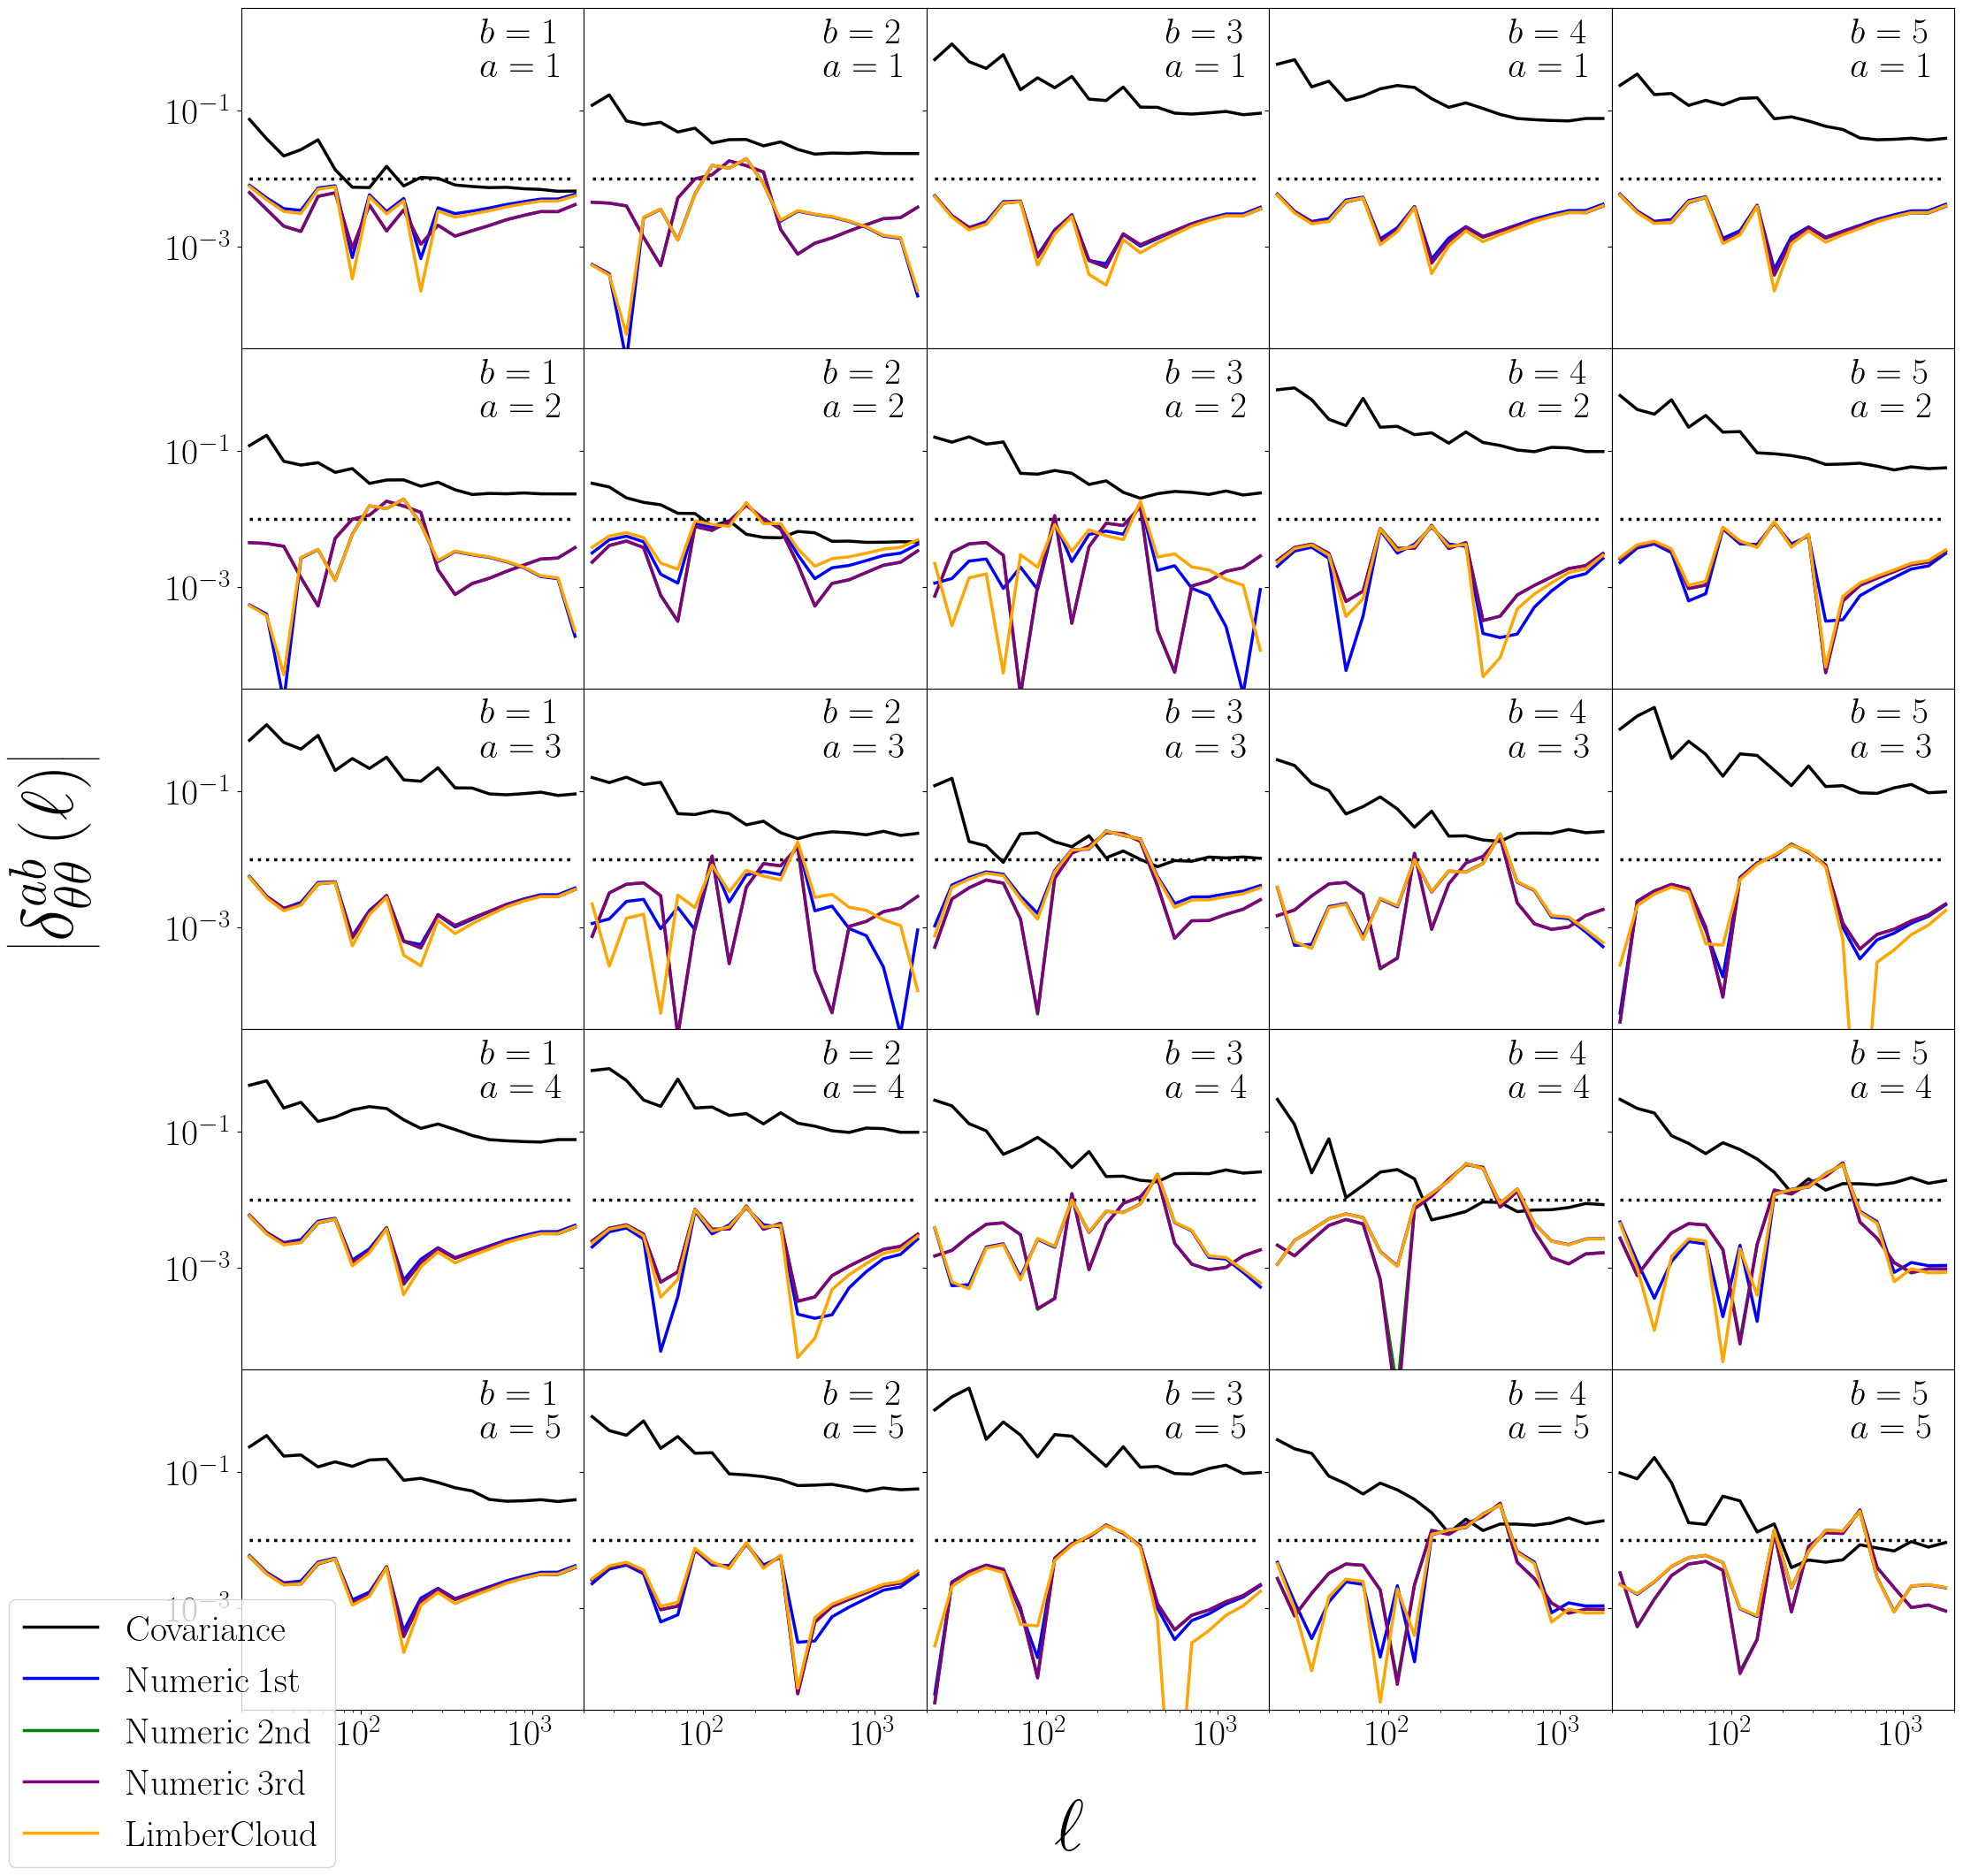

In [6]:
# Figure
os.environ['PATH'] = '/pscratch/sd/y/yhzhang/texlive/2025/bin/x86_64-linux:' + os.environ['PATH']
pyplot.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
pyplot.rcParams['pgf.texsystem'] = 'pdflatex'
pyplot.rcParams['text.usetex'] = True
pyplot.rcParams['font.size'] = 30

FIGURE, AXES = pyplot.subplots(nrows=LENS_BIN_SIZE, ncols=LENS_BIN_SIZE, figsize = (LENS_BIN_SIZE * 5, LENS_BIN_SIZE * 5))

for (BIN_INDEX1, BIN_INDEX2) in product(range(LENS_BIN_SIZE), range(LENS_BIN_SIZE)):
    PLOT = AXES[BIN_INDEX1, BIN_INDEX2]
    
    PLOT.plot(ELL_DATA, numpy.ones(ELL_SIZE) * 0.01, color='black', linestyle=':', linewidth=2.5)
    
    PLOT.plot(ELL_DATA, C_SIGMA_TT[BIN_INDEX1, BIN_INDEX2,:], color='black', linestyle='-', linewidth=2.5)
    
    PLOT.plot(ELL_DATA, C_ERROR1_TT[BIN_INDEX1, BIN_INDEX2,:], color='blue', linestyle='-', linewidth=2.5, label=r'$\mathrm{Numeric \: 1st}$')
    
    PLOT.plot(ELL_DATA, C_ERROR2_TT[BIN_INDEX1, BIN_INDEX2,:], color='green', linestyle='-', linewidth=2.5, label=r'$\mathrm{Numeric \: 2nd}$')
    
    PLOT.plot(ELL_DATA, C_ERROR3_TT[BIN_INDEX1, BIN_INDEX2,:], color='purple', linestyle='-', linewidth=2.5, label=r'$\mathrm{Numeric \: 3rd}$')
    
    PLOT.plot(ELL_DATA, C_ERROR_TT[BIN_INDEX1, BIN_INDEX2,:], color='orange', linestyle='-', linewidth=2.5, label=r'$\mathrm{LimberCloud}$')
    
    PLOT.text(x = 500, y = 10**-0.5, s = r'$a = {:.0f}$'.format(BIN_INDEX1 + 1))
    PLOT.text(x = 500, y = 10**-0.0, s = r'$b = {:.0f}$'.format(BIN_INDEX2 + 1))
    
    PLOT.set_yscale('log')
    PLOT.set_xscale('log')
    PLOT.set_xlim(ELL1, ELL2)
    PLOT.set_ylim(10**-4.5, 10**+0.5)
    
    if BIN_INDEX1 < LENS_BIN_SIZE - 1: 
        PLOT.set_xticklabels([])
    if BIN_INDEX2 > 0: 
        PLOT.set_yticklabels([])

LEGEND = [
    mlines.Line2D([], [], color='black', linestyle='-', linewidth=2.5, label=r'$\mathrm{Covariance}$'),
    mlines.Line2D([], [], color='blue', linestyle='-', linewidth=2.5, label=r'$\mathrm{Numeric \: 1st}$'),
    mlines.Line2D([], [], color='green', linestyle='-', linewidth=2.5, label=r'$\mathrm{Numeric \: 2nd}$'),
    mlines.Line2D([], [], color='purple', linestyle='-', linewidth=2.5, label=r'$\mathrm{Numeric \: 3rd}$'),
    mlines.Line2D([], [], color='orange', linestyle='-', linewidth=2.5, label=r'$\mathrm{LimberCloud}$')
]

FIGURE.legend(
    fontsize=30, 
    handles=LEGEND, 
    loc='upper left', 
    borderaxespad=0.0,
    bbox_to_anchor=(0.02, 0.16)
)

FIGURE.supxlabel(r'$\ell$', fontsize=60, y=0.04)
FIGURE.supylabel(r'$\left| \delta^{a b}_{\theta \theta} \left(\ell\right) \right|$', fontsize=60, x=0.02)

FIGURE.subplots_adjust(hspace=0.0, wspace=0.0)
FIGURE.savefig(os.path.join(PLOT_FOLDER, 'ERROR_TT.pdf'), bbox_inches='tight')